In [7]:
import tensorflow as tf
import pandas as pd
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import matplotlib.cm as cm
import geopandas as gpd
import numpy as np

In [8]:
tabla = pd.read_csv('../data/sird_constantes_dia.csv')
data_set = pd.read_csv('../data/economicas_clima.csv', index_col=0)
data = tabla[['fecha', 'departamento', 'susceptibles', 'infectados', 'recuperados',
       'decesos', 'cantidad_mayores_65', 'ipm', 'poblacion_total',
       'personas_km2', 'edad_promedio', 'promedio_morbilidades']]
indexes = data_set.index
data_embeddings = data[data.fecha == '2020-07-18']
data_embeddings.set_index(data_embeddings['departamento'], drop=True,inplace=True)
data_embeddings = data_embeddings.drop(columns=['departamento', 'fecha'])
data_set = data_set.drop(['Guainía', 'Guaviare', 'Vichada'])
data_embeddings = data_embeddings.sort_index()
aux_index = data_set.index
data_set = data_set.set_index(aux_index)
data_embeddings = data_embeddings.join(data_set)
normalized_df = (data_embeddings-data_embeddings.mean())/data_embeddings.std()
normalized_df = normalized_df.fillna(0)

## Stacked autoencoder

In [10]:
normalized_df.shape
original_dimension = normalized_df.shape[1]

In [20]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='selu', input_shape=[original_dimension]),
    tf.keras.layers.Dense(3, activation= 'selu')
])
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='selu'),
    tf.keras.layers.Dense(original_dimension, activation='sigmoid')
])

stacked_ae = tf.keras.models.Sequential([encoder, decoder])
stacked_ae.compile(loss = 'mse', optimizer=tf.keras.optimizers.SGD(lr=0.1))

In [21]:
history = stacked_ae.fit(normalized_df, normalized_df, epochs=20)
codings = encoder.predict(normalized_df)

Train on 30 samples
Epoch 1/20
30/30 [==============================] - 0s 11ms/sample - loss: 0.3785
Epoch 2/20
30/30 [==============================] - 0s 67us/sample - loss: 0.3780
Epoch 3/20
30/30 [==============================] - 0s 74us/sample - loss: 0.3775
Epoch 4/20
30/30 [==============================] - 0s 60us/sample - loss: 0.3771
Epoch 5/20
30/30 [==============================] - 0s 58us/sample - loss: 0.3766
Epoch 6/20
30/30 [==============================] - 0s 56us/sample - loss: 0.3761
Epoch 7/20
30/30 [==============================] - 0s 45us/sample - loss: 0.3756
Epoch 8/20
30/30 [==============================] - 0s 49us/sample - loss: 0.3752
Epoch 9/20
30/30 [==============================] - 0s 48us/sample - loss: 0.3747
Epoch 10/20
30/30 [==============================] - 0s 59us/sample - loss: 0.3742
Epoch 11/20
30/30 [==============================] - 0s 56us/sample - loss: 0.3737
Epoch 12/20
30/30 [==============================] - 0s 50us/sample - loss: 

In [39]:
def choose_cluster_fit(vectors):
    cum_inertia_kmeans = []
    cum_inertia_kmedoids = []
    for i in range(1,len(vectors) + 1):
        kmeans = KMeans(i,random_state=42)
        kmeans.fit(vectors)
        cum_inertia_kmeans.append(kmeans.inertia_)
    for i in range(1,len(vectors)):
        kmedoids = KMedoids(i,random_state=42)
        kmedoids.fit(vectors)
        cum_inertia_kmedoids.append(kmedoids.inertia_)
    return cum_inertia_kmeans, cum_inertia_kmedoids 

In [40]:
cum_inertia_kmeans, cum_inertia_kmedoids = choose_cluster_fit(codings)

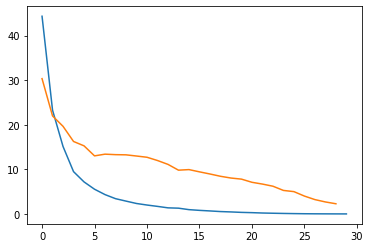

In [41]:
print(plt.plot(cum_inertia_kmeans))
print(plt.plot(cum_inertia_kmedoids))

In [54]:
kmeans = KMeans(5,random_state=42)
kmedioids = KMedoids(6,random_state=42)
kmeans.fit(codings)
kmedioids.fit(codings)
clusters_kmeans = kmeans.predict(codings)
clusters_kmedioids = kmedioids.predict(codings)

In [55]:
political_map = gpd.read_file("map/MGN_DPTO_POLITICO.shp")
political_map.set_index(political_map.DPTO_CNMBR ,inplace=True)
political_map = political_map.sort_index()
political_map.set_index(indexes ,inplace=True)
political_map['cluster'] = 3
political_map['cluster'].loc[aux_index] = clusters_kmeans + 4

/Users/santiagocortes/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


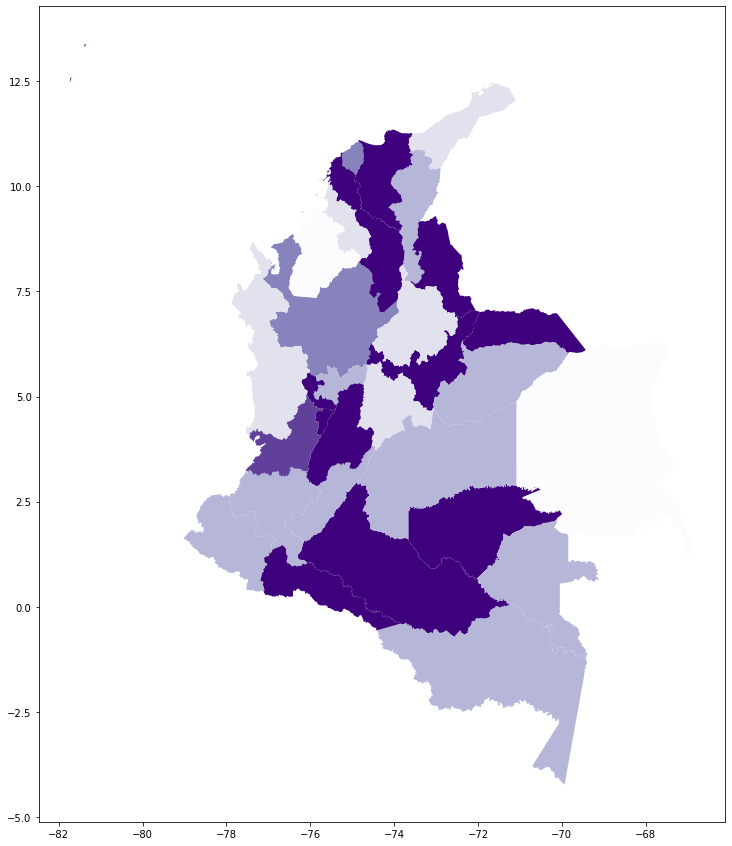

In [56]:
fig, ax = plt.subplots(figsize=(15, 15))
political_map.plot(column="cluster", ax=ax, cmap="Purples")

## Shared weights autoencoder

In [36]:
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias", initializer="zeros",
                                    shape=[self.dense.input_shape[-1]])
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [52]:
dense_1 = tf.keras.layers.Dense(64, activation="selu",input_shape=[original_dimension])
dense_2 = tf.keras.layers.Dense(5, activation="selu")
encoder = tf.keras.models.Sequential([
    dense_1,
    dense_2
])
decoder = tf.keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
])

stacked_ae = tf.keras.models.Sequential([encoder, decoder])
stacked_ae.compile(loss = 'mse', optimizer=tf.keras.optimizers.SGD(lr=0.1))

In [53]:
history = stacked_ae.fit(normalized_df, normalized_df, epochs=80)
codings = encoder.predict(normalized_df)

Train on 30 samples
Epoch 1/80
30/30 [==============================] - 0s 8ms/sample - loss: 0.3632
Epoch 2/80
30/30 [==============================] - 0s 53us/sample - loss: 0.3627
Epoch 3/80
30/30 [==============================] - 0s 62us/sample - loss: 0.3623
Epoch 4/80
30/30 [==============================] - 0s 66us/sample - loss: 0.3619
Epoch 5/80
30/30 [==============================] - 0s 55us/sample - loss: 0.3614
Epoch 6/80
30/30 [==============================] - 0s 59us/sample - loss: 0.3610
Epoch 7/80
30/30 [==============================] - 0s 58us/sample - loss: 0.3605
Epoch 8/80
30/30 [==============================] - 0s 52us/sample - loss: 0.3601
Epoch 9/80
30/30 [==============================] - 0s 55us/sample - loss: 0.3596
Epoch 10/80
30/30 [==============================] - 0s 50us/sample - loss: 0.3591
Epoch 11/80
30/30 [==============================] - 0s 55us/sample - loss: 0.3587
Epoch 12/80
30/30 [==============================] - 0s 56us/sample - loss: 0